# Quiz 2

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

In [3]:
h21 = pd.read_csv("homework_2.1.csv")
h22 = pd.read_csv("homework_2.2.csv")

In [4]:
h21

,time,G1,G2,G3
0,0,0.882026,1.441575,0.065409
1,1,0.210079,-0.163880,0.140310
2,2,0.509369,-0.115242,0.819830
3,3,1.150447,1.014698,0.607632
4,4,0.973779,-0.046562,0.610066
...,...,...,...,...
95,95,1.303287,1.364227,1.768446
96,96,0.965250,1.845895,1.258862
97,97,1.862935,1.881752,1.511477
98,98,1.043456,2.561618,1.030275


In [18]:
# Melt the dataframe to long format: time, group, y
df_long = pd.melt(h21, id_vars=['time'], value_vars=['G1', 'G2', 'G3'], 
                  var_name='group', value_name='y')

# Create group dummies
group_dummies = pd.get_dummies(df_long['group'])

# Design matrix: add constant, time, and group dummies
X_design = pd.concat([df_long[['time']], group_dummies], axis=1)

# Ensure all columns are float to avoid object dtype
X_design = X_design.astype(float)

# Fit OLS with fixed effects
model = sm.OLS(df_long['y'], X_design).fit()

# Print parameters
print(model.params)

# The coefficient for group 1 is the constant term
# The common linear coefficient is the 'time' coefficient

time    0.009017
G1      0.078552
G2      0.589654
G3      0.269032
dtype: float64


In [20]:
df_long

,time,group,y
0,0,G1,0.882026
1,1,G1,0.210079
2,2,G1,0.509369
3,3,G1,1.150447
4,4,G1,0.973779
...,...,...,...
295,95,G3,1.768446
296,96,G3,1.258862
297,97,G3,1.511477
298,98,G3,1.030275


In [22]:
group_dummies

,G1,G2,G3
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
295,False,False,True
296,False,False,True
297,False,False,True
298,False,False,True


In [23]:
X_design

,time,G1,G2,G3
0,0.0,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0
2,2.0,1.0,0.0,0.0
3,3.0,1.0,0.0,0.0
4,4.0,1.0,0.0,0.0
...,...,...,...,...
295,95.0,0.0,0.0,1.0
296,96.0,0.0,0.0,1.0
297,97.0,0.0,0.0,1.0
298,98.0,0.0,0.0,1.0


In [26]:
h22

,X,Y,Z
0,0,1.182435,-0.725820
1,0,2.714474,0.563476
2,0,0.077612,-0.435632
3,0,-0.154449,-0.104553
4,0,22.298992,-2.321273
...,...,...,...
9995,0,0.019371,-0.409462
9996,0,2.581533,0.545860
9997,0,0.209599,-0.486216
9998,0,16.829356,-2.045500


In [27]:
h22.query("X == 1")['Y'].mean() - h22.query("X == 0")['Y'].mean()

np.float64(2.920717264723189)

In [29]:
# Bootstrapping function
def bootstrap_df(df, num_samples=100000):
    n = len(df)
    stats = []
    for _ in range(num_samples):
        sample = df.sample(n, replace=True)  # resample rows
        effect = sample.query("X == 1")['Y'].mean() - sample.query("X == 0")['Y'].mean()
        stats.append(effect)
    return np.array(stats)

boot_effects = bootstrap_df(h22, num_samples=100000)
boot_effects.var()


np.float64(0.03202587480967065)

In [35]:
# Bootstrapping function
def bootstrap_df(df, num_samples=100000):
    n = len(df)
    stats = []
    for _ in range(num_samples):
        sample = df.sample(n, replace=True)  # resample rows
        results = sm.OLS(sample.Y, sm.add_constant(sample.X)).fit()
        effect = results.params.iloc[1]
        stats.append(effect)
    return np.array(stats)

boot_effects = bootstrap_df(h22, num_samples=100000)
skewness = scipy.stats.skew(boot_effects)


In [36]:
skewness

np.float64(0.042982254720913514)

In [38]:
# Bootstrapping function
def bootstrap_df(df, num_samples=100000):
    n = len(df)
    stats = []
    for _ in range(num_samples):
        sample = df.sample(n, replace=True)  # resample rows
        results = sm.OLS(sample.Y, sm.add_constant(sample[["X", "Z"]])).fit()
        effect = results.params.iloc[1]
        stats.append(effect)
    return np.array(stats)

boot_effects = bootstrap_df(h22, num_samples=100000)
skewness = scipy.stats.skew(boot_effects)
skewness

np.float64(0.04004019467701297)

# Reflection

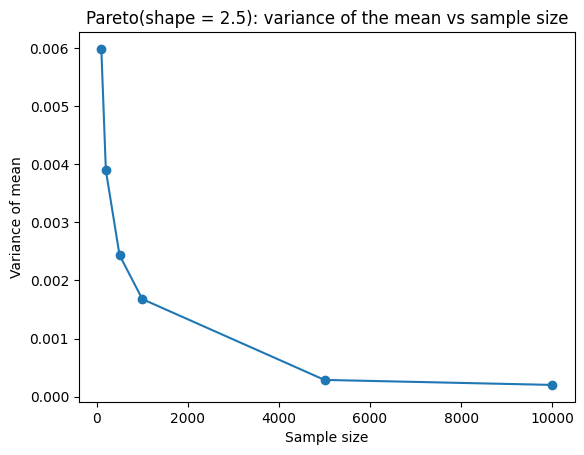

   sample_size  variance_of_mean
0          100          0.005981
1          200          0.003890
2          500          0.002434
3         1000          0.001678
4         5000          0.000288
5        10000          0.000202


In [68]:
# Make results repeatable
np.random.seed(42)

# Pareto settings
pareto_shape = 2.5     # shape, must be > 2 for finite variance
pareto_minimum = 1.0   # minimum value

def draw_pareto_samples(num_samples, shape=pareto_shape, minimum=pareto_minimum):
    # Make num_samples from a Pareto(shape) with minimum value
    return (np.random.pareto(shape, size=num_samples) + 1.0) * minimum

def bootstrap_variance_of_mean(data, num_bootstrap_samples=2000):
    # Resample with replacement and record the mean each time
    sample_size = len(data)
    bootstrap_means = np.empty(num_bootstrap_samples)
    for i in range(num_bootstrap_samples):
        resampled_data = np.random.choice(data, size=sample_size, replace=True)
        bootstrap_means[i] = resampled_data.mean()
    return bootstrap_means.var(ddof=1), bootstrap_means  # sample variance

# Try different sample sizes
sample_sizes = [100, 200, 500, 1000, 5000, 10000]
variance_of_means = []

for sample_size in sample_sizes:
    data = draw_pareto_samples(sample_size)
    variance_estimate, _ = bootstrap_variance_of_mean(data, num_bootstrap_samples=2000)
    variance_of_means.append(variance_estimate)

# Plot: variance of the mean should go down as sample size grows
plt.plot(sample_sizes, variance_of_means, marker="o")
plt.xlabel("Sample size")
plt.ylabel("Variance of mean")
plt.title("Pareto(shape = 2.5): variance of the mean vs sample size")
plt.show()

# Table of results
results_df = pd.DataFrame({
    "sample_size": sample_sizes,
    "variance_of_mean": variance_of_means
})
print(results_df)
